In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

pd.options.display.float_format = "{:.3f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

import pickle
from datetime import datetime

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [4]:
def load_results(file_name):
    data = None
    with open(file_name, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data = pickle.load(f)
    return data

def filter_top_model_results(top_models, all_model_results):
    plot_data = list()
    for idx, row in top_models.iterrows():
        #print("row.label: " + row.label + ',' + row.classifier + ',' + row.sampling_method)
        for res in all_model_results:       
            for alg_results in res:
                if alg_results[0] == row.label and alg_results[1] == row.classifier and alg_results[2] == row.sampling_method:
                    #print(alg_results)
                    label, model_name, sampling_method, _, tpr, fpr, roc_auc, precision, recall, prc_auc = alg_results

                    plot_data.append(("{} :: {}".format(model_name + '::' + row.time_budget, sampling_method), tpr, fpr, roc_auc, precision, recall, prc_auc))
    return plot_data

def rebuild_results(res):
    ## Gather all the metrics
    temp_metrics = pd.DataFrame()
    temp_results = list()
    for i in range(0, len(res)):
        temp_metrics = pd.concat([temp_metrics, res[i][1]])
        temp_results.append(res[i][2]) 
    
    return temp_metrics, temp_results

In [5]:
measurements = ['label', 'classifier', 'sampling_method', \
                #'fp', 'fn',\
                'balanced_accuracy', 'recall', 'precision', \
                 #'f1_score',\
                'time_budget', 'aucroc', 'auprc',\
                'model_churn_cost']

measurements_alias = ['label', 'classifier', 'sampling', \
                      'bal_acc', 'recall', 'precision',\
                      # 'f1',\
                      'time_budget', 'auroc', 'auprc',\
                      'churn_cost']

## Summarise performance of the approaches

In [6]:
## First Experiment:
## Approach 1.1 - Churn BasicData + Default Hyper

#exp1_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Basic_DefaultHyper_2019-08-12.pickle')
#exp2_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Manual_GridSearch_2019-08-10.pickle')
#exp2_2 = load_results('/home/dissertation/code/RESULTS_FINAL/Manual_RdmSearch_2019-08-10.pickle')
#exp3_1 = load_results('/home/dissertation/code/RESULTS_FINAL/DFS_Default_2019-08-10.pickle')

#exp4_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Basic_Asklearn_20190813.pickle')

#exp4_2 = load_results('/home/dissertation/code/RESULTS_FINAL/Manual_Asklearn_20190816.pickle')

exp4_3 = load_results('/home/dissertation/code/RESULTS_FINAL/DFS_Asklearn_20190818.pickle')
                      
exp_metrics, exp_results = rebuild_results(exp4_3)

In [7]:
#exp_metrics[['classifier', 'sampling_method','accuracy']].groupby(['sampling_method']).count()

In [8]:
exp_metrics.head()

label             classifier sampling_method  \
0  ASKLEARN_10_askbasic_Nonecv_recall  AutoSklearnClassifier         RUS 1:1   
0  ASKLEARN_15_askbasic_Nonecv_recall  AutoSklearnClassifier         RUS 1:1   
0  ASKLEARN_20_askbasic_Nonecv_recall  AutoSklearnClassifier         RUS 1:1   
0  ASKLEARN_25_askbasic_Nonecv_recall  AutoSklearnClassifier         RUS 1:1   
0  ASKLEARN_30_askbasic_Nonecv_recall  AutoSklearnClassifier         RUS 1:1   

       tn    fn     tp     fp  accuracy  precision  recall  ...  log_loss  \
0  214576  4385  19676  18850     0.910      0.511   0.818  ...     3.117   
0  216888  4340  19721  16538     0.919      0.544   0.820  ...     2.801   
0  218506  4665  19396  14920     0.924      0.565   0.806  ...     2.627   
0  216492  4334  19727  16934     0.917      0.538   0.820  ...     2.853   
0  217092  4387  19674  16334     0.920      0.546   0.818  ...     2.780   

   train_time  cv_time  aucroc  auprc  balanced_accuracy  cv_score_mean  \
0     933.560    0.000   0.950  0.744              0.869             -1   
0    1111.580    0.000   0.954  0.771              0.874             -1   
0    1531.807    0.000   0.952  0.747              0.871             -1   
0    1802.441    0.000   0.953  0.763              0.874             -1   
0    2227.112    0.000   0.952  0.761              0.874             -1   

   cv_score_std model_churn_cost sample  
0            -1          6045100      0  
0            -1          5795900      0  
0            -1          5764100      0  
0            -1          5833100      0  
0            -1          5794300      0  

[5 rows x 22 columns]

In [9]:
# Convert train_time
exp_metrics['train_time'] = (exp_metrics['train_time']/60)
exp_metrics['cv_time'] = (exp_metrics['cv_time']/60)

# Convert model_churn_cost to EUR from TWD
exp_metrics['model_churn_cost'] = np.round(exp_metrics['model_churn_cost'] * 0.029).astype(int)
exp_metrics['time_budget'] = exp_metrics.label.str.replace('[^0-9]', '', regex=True)

In [10]:
measure_by = ['balanced_accuracy', 'recall', 'model_churn_cost']
measure_by_sort = [False, False, True]

# measure_by = ['balanced_accuracy']
# measure_by_sort = [False]

# measure_by = ['model_churn_cost']
# measure_by_sort = [True]

# measure_by = ['f1_score']
# measure_by_sort = [False]

### The best/worst 5 performing models as measured by .... 

In [21]:
### print("Getting best results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))

top_results = exp_metrics.sort_values(measure_by, ascending=measure_by_sort)
top_results = top_results[measurements].head(5)
top_results['classifier'] = top_results['classifier'].apply(lambda v: str(v).replace('Classifier', ''))

### The lowest 5 performing models by approach as measured by .... 
print("Getting worst results for {} / ordered ascending? {}".format(measure_by, [not f for f in measure_by_sort]))
worst_results = exp_metrics\
                .sort_values(measure_by, ascending=[not f for f in measure_by_sort])
worst_results = worst_results[measurements].head(5)
worst_results['classifier'] = worst_results['classifier'].apply(lambda v: str(v).replace('Classifier', ''))

temp = pd.concat([top_results, worst_results])
temp.columns = measurements_alias
temp

print(temp.to_latex(index=False))

Getting worst results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [True, True, False]
\begin{tabular}{lllrrrlrrr}
\toprule
                              label &   classifier & sampling &  bal\_acc &  recall &  precision & time\_budget &  auroc &  auprc &  churn\_cost \\
\midrule
 ASKLEARN\_55\_askbasic\_Nonecv\_recall &  AutoSklearn &  RUS 1:1 &    0.880 &   0.831 &      0.547 &          55 &  0.954 &  0.769 &      165039 \\
 ASKLEARN\_40\_askbasic\_Nonecv\_recall &  AutoSklearn &  RUS 1:1 &    0.876 &   0.822 &      0.545 &          40 &  0.953 &  0.771 &      167284 \\
 ASKLEARN\_60\_askbasic\_Nonecv\_recall &  AutoSklearn &  RUS 1:1 &    0.875 &   0.821 &      0.546 &          60 &  0.953 &  0.771 &      167466 \\
 ASKLEARN\_35\_askbasic\_Nonecv\_recall &  AutoSklearn &  RUS 1:1 &    0.875 &   0.822 &      0.540 &          35 &  0.953 &  0.767 &      168229 \\
 ASKLEARN\_45\_askbasic\_Nonecv\_recall &  AutoSklearn &  RUS 1:1 &    0.874 &   0.821 &   

In [ ]:
# exp_metrics[['label','classifier','sampling_method','accuracy','precision','recall','tp','tn','fp','fn']]

### Summary performance statistics of classifiers over all sampling techniques

In [14]:
## Excludes LR and MLP as those produce bad classifiers

stats_summary = {'best':max,
                 'median':'median', 
                 'iqr':lambda x: np.percentile(x, 75, interpolation='higher') - np.percentile(x, 25, interpolation='lower'),
                 #'range':lambda x: max(x) - min(x)
                }
#[~exp_metrics.recall.isin([0.0, 1.0])]
summary = \
    exp_metrics\
            .groupby(['time_budget'])\
            .agg({
                 'balanced_accuracy':stats_summary,
                 'recall':stats_summary,
                 'precision':stats_summary,
                 'model_churn_cost':{'best':min},
                 #'aucroc':stats_summary,
                 #'auprc':stats_summary,
                 'train_time':'median',
                 })\
            .reset_index()\
            .sort_values(('balanced_accuracy', 'best'), ascending=False)
summary
#print(summary.to_latex(index=False))

/home/anaconda/envs/py373/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


time_budget balanced_accuracy              recall              precision  \
                            best median   iqr   best median   iqr      best   
9           55             0.880  0.765 0.043  0.831  0.545 0.132     0.852   
6           40             0.876  0.798 0.040  0.822  0.622 0.100     0.867   
10          60             0.875  0.800 0.057  0.821  0.623 0.160     0.872   
5           35             0.875  0.793 0.029  0.822  0.616 0.082     0.851   
7           45             0.874  0.786 0.047  0.821  0.591 0.120     0.858   
1           15             0.874  0.775 0.102  0.820  0.647 0.235     0.796   
8           50             0.874  0.768 0.032  0.820  0.561 0.063     0.875   
4           30             0.874  0.797 0.035  0.818  0.635 0.104     0.796   
3           25             0.874  0.751 0.052  0.820  0.631 0.149     0.857   
2           20             0.871  0.771 0.057  0.806  0.583 0.199     0.870   
0           10             0.869  0.571 0.240  0.818  0.171 0.566     0.617   

                model_churn_cost train_time  
   median   iqr             best     median  
9   0.680 0.284           165039     55.929  
6   0.711 0.116           167284     41.267  
10  0.744 0.226           167466     61.126  
5   0.674 0.130           168229     36.396  
7   0.715 0.191           168467     46.555  
1   0.492 0.133           168081     15.629  
8   0.750 0.064           168333     51.422  
4   0.616 0.190           168035     30.974  
3   0.538 0.459           169160     25.938  
2   0.542 0.294           167159     20.469  
0   0.410 0.264           175308     10.336

### The best performing sampling methods by classifier as measured by .... 

In [15]:
print("Getting results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))

top_results = exp_metrics.sort_values(measure_by, ascending=measure_by_sort).groupby(['sampling_method']).head(1)
top_results = top_results[measurements]
top_results['classifier'] = top_results['classifier'].apply(lambda v: str(v).replace('Classifier', ''))
top_results

#print(top_results.to_latex(index=True))

Getting results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [False, False, True]


label   classifier sampling_method  \
0  ASKLEARN_55_askbasic_Nonecv_recall  AutoSklearn         RUS 1:1   
0  ASKLEARN_45_askbasic_Nonecv_recall  AutoSklearn         ROS 1:1   
0  ASKLEARN_45_askbasic_Nonecv_recall  AutoSklearn        SMOTE_NC   
0  ASKLEARN_60_askbasic_Nonecv_recall  AutoSklearn         ROS 2:1   
0  ASKLEARN_60_askbasic_Nonecv_recall  AutoSklearn         ROS 3:1   
0  ASKLEARN_40_askbasic_Nonecv_recall  AutoSklearn         ROS 3:2   
0  ASKLEARN_45_askbasic_Nonecv_recall  AutoSklearn            None   

   balanced_accuracy  recall  precision time_budget  aucroc  auprc  \
0              0.880   0.831      0.547          55   0.954  0.769   
0              0.810   0.650      0.682          45   0.927  0.705   
0              0.806   0.664      0.570          45   0.930  0.685   
0              0.803   0.631      0.717          60   0.930  0.714   
0              0.800   0.623      0.744          60   0.939  0.728   
0              0.798   0.622      0.716          40   0.924  0.708   
0              0.743   0.494      0.858          45   0.941  0.739   

   model_churn_cost  
0            165039  
0            188532  
0            198435  
0            190046  
0            189964  
0            192421  
0            216586

### The best performing models by sampling method as measured by .... 

In [16]:
print("Getting results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))
top_results = exp_metrics[(exp_metrics.recall > 0) & (exp_metrics.recall < 1)]\
                    .sort_values(measure_by, ascending=measure_by_sort).groupby('sampling_method').head(1)
top_results = top_results[measurements]
top_results.sort_values('balanced_accuracy', ascending=False)

Getting results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [False, False, True]


label             classifier sampling_method  \
0  ASKLEARN_55_askbasic_Nonecv_recall  AutoSklearnClassifier         RUS 1:1   
0  ASKLEARN_45_askbasic_Nonecv_recall  AutoSklearnClassifier         ROS 1:1   
0  ASKLEARN_45_askbasic_Nonecv_recall  AutoSklearnClassifier        SMOTE_NC   
0  ASKLEARN_60_askbasic_Nonecv_recall  AutoSklearnClassifier         ROS 2:1   
0  ASKLEARN_60_askbasic_Nonecv_recall  AutoSklearnClassifier         ROS 3:1   
0  ASKLEARN_40_askbasic_Nonecv_recall  AutoSklearnClassifier         ROS 3:2   
0  ASKLEARN_45_askbasic_Nonecv_recall  AutoSklearnClassifier            None   

   balanced_accuracy  recall  precision time_budget  aucroc  auprc  \
0              0.880   0.831      0.547          55   0.954  0.769   
0              0.810   0.650      0.682          45   0.927  0.705   
0              0.806   0.664      0.570          45   0.930  0.685   
0              0.803   0.631      0.717          60   0.930  0.714   
0              0.800   0.623      0.744          60   0.939  0.728   
0              0.798   0.622      0.716          40   0.924  0.708   
0              0.743   0.494      0.858          45   0.941  0.739   

   model_churn_cost  
0            165039  
0            188532  
0            198435  
0            190046  
0            189964  
0            192421  
0            216586

### Classifier train time distribution by sampling method

Text(0.5, 0, 'Sampling Method')

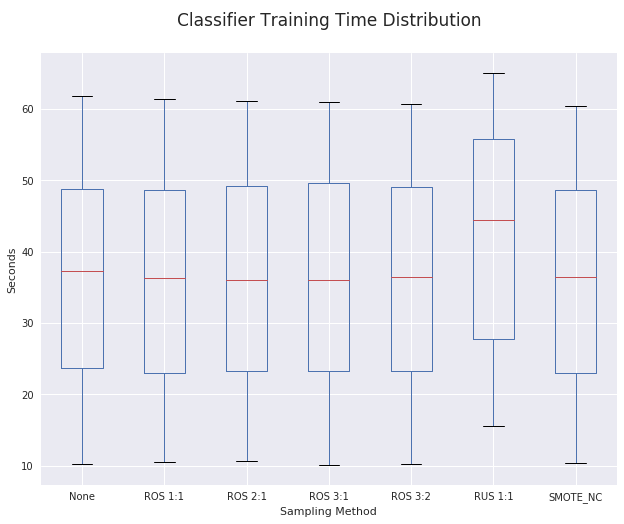

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
plt.ylabel('Seconds')
exp_metrics.boxplot(column='train_time', by='sampling_method', ax=ax)
plt.title('Classifier Training Time Distribution\n', size=17)
plt.suptitle(' ')
plt.xlabel('Sampling Method')

### Recall/Bal Acc performance over time_budgets or sampling_method

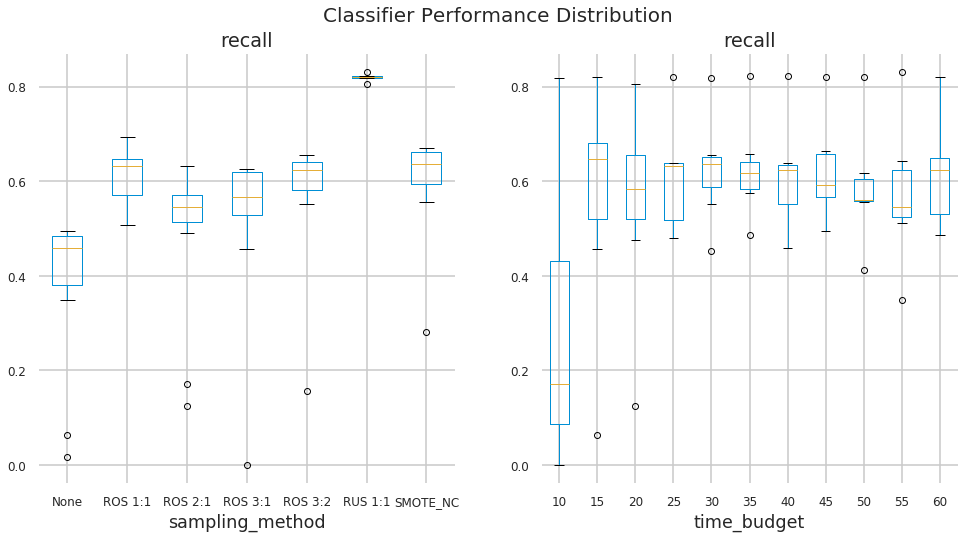

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

exp_metrics.boxplot(column='recall', by='sampling_method', ax=axes[0])
#plt.ylabel('')
#plt.title('Classifier Performance Distribution\n', size=17)
#plt.suptitle(' ')
#plt.xlabel('Sampling Method')


exp_metrics.boxplot(column='recall', by='time_budget', ax=axes[1])
#plt.ylabel('')
#plt.title('Classifier Performance Distribution\n', size=17)
#plt.suptitle(' ')
#plt.xlabel('Time Budget')

fig = axes[1].get_figure()
fig.suptitle('Classifier Performance Distribution\n', size=20)

fig = axes[0].get_figure()
#fig.ylabel('Classifier Performance Distribution\n', size=20)

In [74]:
plt.style.use('seaborn-poster')
#plt.style.use('fivethirtyeight')
plt.rcParams['axes.edgecolor'] = '#ffffff'
plt.rcParams['axes.facecolor'] = '#ffffff'
plt.rcParams['figure.facecolor'] = '#ffffff'
plt.rcParams['patch.edgecolor'] = '#ffffff'
plt.rcParams['patch.facecolor'] = '#ffffff'
plt.rcParams['savefig.edgecolor'] = '#ffffff'
plt.rcParams['savefig.facecolor'] = '#ffffff'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Text(0.5, 0, 'Time Budget')

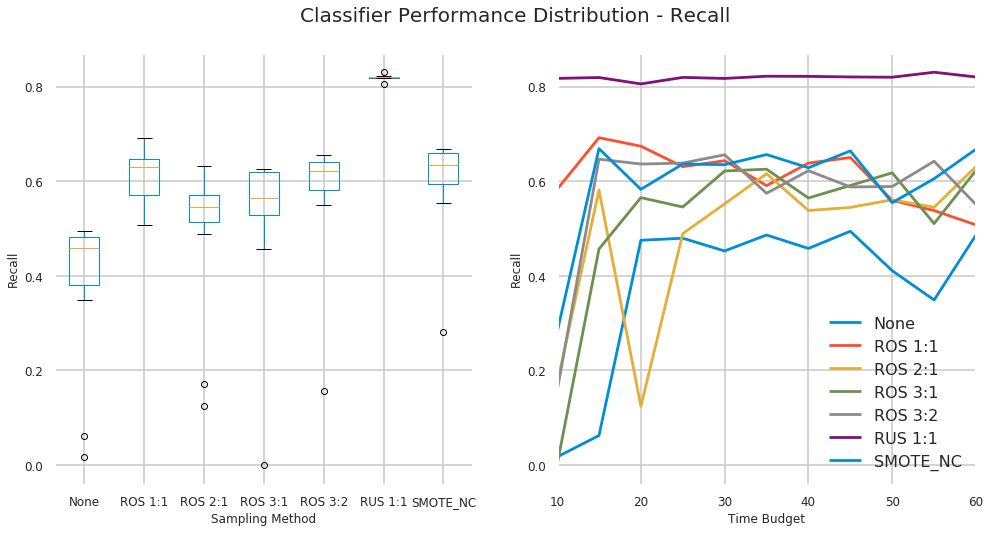

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

exp_metrics.boxplot(column='recall', by='sampling_method', ax=axes[0])
#plt.xlabel('Sampling Method')
#plt.ylabel('Recall')
#plt.suptitle(' ')

## Plot the balanced_accuracy over time grouped by sampling_method
df = exp_metrics.copy(deep=True)
df.set_index('time_budget', inplace=True)

df.groupby('sampling_method')['recall'].plot(legend=True, ax=axes[1], title='recall')
#plt.xlabel('Time Budget')

plt.ylabel('Recall')
plt.suptitle(' ')


fig = axes[0].get_figure()
fig.suptitle('Classifier Performance Distribution - Recall\n', size=20)

axes[0].set_title("")
axes[1].set_title("")

axes[0].set_ylabel("Recall", fontsize=12)
axes[1].set_ylabel("Recall", fontsize=12)

axes[0].set_xlabel("Sampling Method", fontsize=12)
axes[1].set_xlabel("Time Budget", fontsize=12)


### For this approach plot the best models by classifier

Getting best results by classifier based on ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [False, False, True]


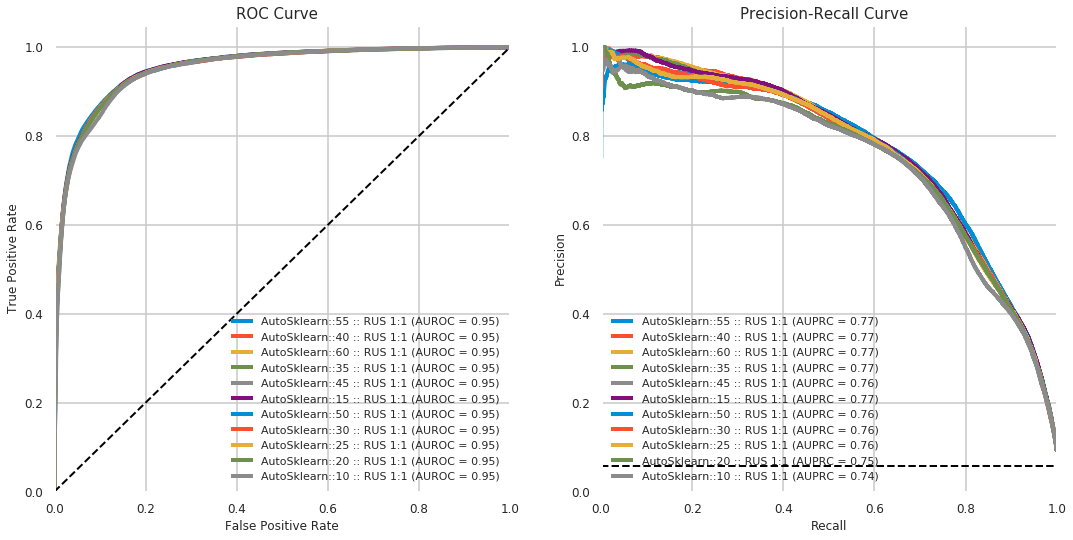

In [77]:
print("Getting best results by classifier based on {} / ordered ascending? {}".format(measure_by, measure_by_sort))

temp_metrics = exp_metrics.copy()
temp_metrics['classifier_label'] = temp_metrics["classifier"] + " :: " + temp_metrics["time_budget"]

plot_results = temp_metrics.sort_values(measure_by, ascending=measure_by_sort).groupby('classifier_label').head(1)
plot_data = filter_top_model_results(plot_results, exp_results)
plot_roc_prc(plot_data, ' ')

### Choosing the best model and appending to overall .... 

In [ ]:
exp1_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Basic_DefaultHyper_2019-08-12.pickle')
exp_metrics, exp_results = rebuild_results(exp1_1)
manualgrid = load_results('Manual_GridSearch_2019-08-05.pickle')

manualrdm = load_results('Manual_RdmSearch_2019-08-05.pickle')

In [ ]:
top_models = pd.DataFrame()

In [ ]:
top_models = top_models.append(exp_metrics.sort_values(measure_by, ascending=measure_by_sort).head(1))

In [ ]:
#filter_top_model_results(exp_metrics.sort_values(measure_by, ascending=measure_by_sort).head(1), exp_results)

In [ ]:
from scipy import stats
import scikit_posthocs as sp

xgb = plot_data[0][-2]
rf = plot_data[1][-2]
dt = plot_data[2][-2]
gnb = plot_data[3][-2]
lr = plot_data[4][-2]
mlp = plot_data[5][-2]

data = [xgb, rf, dt, gnb, lr, mlp]

stats.kruskal(*data)

In [ ]:
sp.posthoc_conover(data)

In [ ]:
#all_metrics[all_metrics.recall < 1.0].sort_values(['recall'], ascending=[False])

In [ ]:
#all_metrics.sort_values(['recall','precision'], ascending=[False, False])

In [ ]:
print(top_results.to_latex(index=False)) # doctest: +NORMALIZE_WHITESPACE

In [ ]:
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
import statsmodels.formula.api as sfa

df = sa.datasets.get_rdataset('iris').data
data = [df.loc[ids, 'Sepal.Width'].values for ids in df.groupby('Species').groups.values()]

In [ ]:
H, p = ss.kruskal(*data)
print(H, p)

In [ ]:
sp.posthoc_conover(df, val_col='Sepal.Width', group_col='Species', p_adjust = 'holm')

In [ ]:
df.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width', 'Species']

In [ ]:
lm = sfa.ols('Sepal_Width ~ C(Species)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

In [ ]:
sp.posthoc_ttest(df, val_col='Sepal_Width', group_col='Species', p_adjust='holm')